* Eleven annotated emotions are provided for images and indexed as follows: 0: Neutral, 1: Happiness, 2: Sadness, 3: Surprise, 4: Fear, 5: Disgust, 6: Anger, 7: Contempt, 8: None, 9: Uncertain, 10: No-Face
* emotional_classes = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

# Data Preparation

In [1]:
#Check GPU
! nvidia-smi

Sun Apr 10 13:51:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:01:00.0 Off |                    0 |
|  0%   55C    P0    65W / 300W |      4MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:25:00.0 Off |                    0 |
|  0%   

In [2]:
#Import Packages
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import re
from sklearn.utils import shuffle
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import cv2

from skimage.transform import resize

In [3]:
#GPU Configuration
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
#Check Package Version
print(cv2.__version__)
print(tf.__version__)

4.5.4
2.6.0


In [5]:
#Check Current Directory
os.getcwd()

'/Data'

In [6]:
#Change Directory to AffectNet
os.chdir("/Data/AffectNet/")

In [7]:
#List Current Directory
os.listdir('/Data/AffectNet/')

['Classification_Report',
 'val_set',
 'val_set.tar',
 '20211219_AffectNet_v7_test.py',
 'Model',
 'train_set',
 'output.txt',
 'train_set.tar']

In [8]:
t = datetime.datetime.now()
t = t.strftime('%Y%m%d')

### Training Data

In [9]:
#Define Directory of Labels
data_path_labels_train = '/Data/AffectNet/train_set/annotations'
data_dir_list_labels_train = os.listdir(data_path_labels_train)

In [10]:
#Define Directory of Images
data_path_images_train = '/Data/AffectNet/train_set/images'
data_dir_list_images_train = os.listdir(data_path_images_train)

In [11]:
#Count Subjects
print(len(data_dir_list_labels_train)//4)
print(len(data_dir_list_images_train))

287651
287651


In [12]:
#Show Elements in the Label List
data_dir_list_labels_train[0:12]

['49010_exp.npy',
 '330335_exp.npy',
 '210670_aro.npy',
 '255004_aro.npy',
 '78658_aro.npy',
 '385409_lnd.npy',
 '102039_aro.npy',
 '159080_lnd.npy',
 '375603_val.npy',
 '276061_lnd.npy',
 '292254_aro.npy',
 '309832_val.npy']

In [13]:
#Check Numpy Read of npy file
for i in range(0, 5):
    print(data_dir_list_labels_train[i])
    print(np.load('/Data/AffectNet/train_set/annotations/' + data_dir_list_labels_train[i]))

49010_exp.npy
1
330335_exp.npy
1
210670_aro.npy
0.74644
255004_aro.npy
-0.163295
78658_aro.npy
0.142225


In [14]:
#Show Elements in the Features List
data_dir_list_images_train[0:12]

['69975.jpg',
 '376822.jpg',
 '15081.jpg',
 '393079.jpg',
 '387637.jpg',
 '81231.jpg',
 '213382.jpg',
 '193664.jpg',
 '331393.jpg',
 '79605.jpg',
 '108751.jpg',
 '125264.jpg']

In [15]:
#0-Neutral, 1-Happiness, 2-Sadness, 3-Surprise, 4-Fear, 5-Disgust, 6-Anger, 7-Contempt, 8-NoNe, 9-Uncertain, 10-No-Face
emotional_classes = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

69975


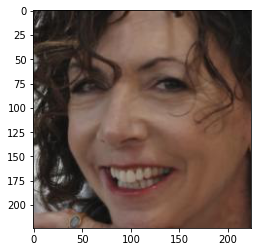

1
Happiness
376822


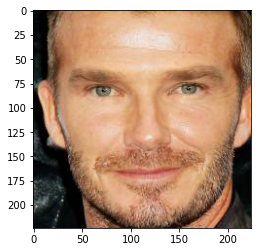

7
Contempt
15081


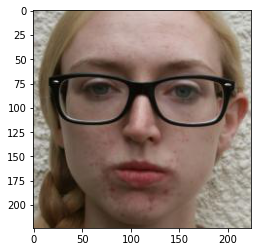

0
Neutral
393079


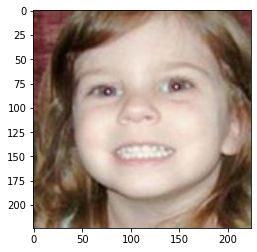

1
Happiness
387637


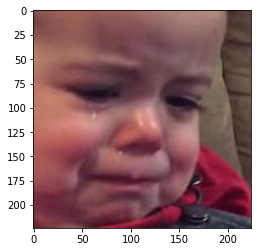

2
Sadness


In [16]:
images_train = []
labels_train = []

for i in range(0,5):
    print(data_dir_list_images_train[i].rsplit('.jpg')[0])
    input_img=plt.imread('/Data/AffectNet/train_set/images/' + data_dir_list_images_train[i])
  
    plt.imshow(input_img)
    plt.show()
    
    temp_id = data_dir_list_images_train[i].rsplit('.jpg')[0]
    print(np.load('/Data/AffectNet/train_set/annotations/' + temp_id + "_exp.npy"))
    temp_index = int(np.load('/Data/AffectNet/train_set/annotations/' + temp_id + "_exp.npy"))
    #print(temp_index)
    print(emotional_classes[temp_index])   

In [17]:
#Create List each for training features and labels
images_train = []
labels_train = []

#Read training features and training labels and store in list
for i in range(len(data_dir_list_images_train)):
    input_img=plt.imread('/Data/AffectNet/train_set/images/' + data_dir_list_images_train[i])
    images_train.append(input_img)
    
    temp_id = data_dir_list_images_train[i].rsplit('.jpg')[0] 
    labels_train.append(int(np.load('/Data/AffectNet/train_set/annotations/' + temp_id + "_exp.npy")))

In [18]:
len(images_train)

287651

In [19]:
len(labels_train)

287651

In [20]:
images_train[0].shape

(224, 224, 3)

In [21]:
labels_train[0]

1

#### Resizing Images_Train

In [22]:
#Function to Rescale Images
def rescale_image(img):
    img = resize(img, (48, 48), anti_aliasing=True) #Anti-Aliasing means Gaussain Smooting // If Anti-AA is True => No Aliasing // If Anti-AA is False => Aliasing (~Mistakes)
    #img_new = img.astype(np.uint8)
    return img

In [23]:
#Create List of Resized Images with 48 x 48 Pixels
images_train_resize = [rescale_image(i) for i in images_train]

In [24]:
print(len(images_train))
print(len(images_train_resize))

287651
287651


In [25]:
print(images_train[0].shape)
print(images_train_resize[0].shape)

(224, 224, 3)
(48, 48, 3)


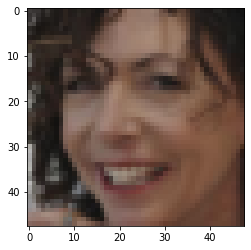

Happiness


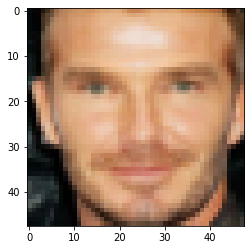

Contempt


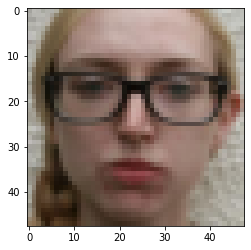

Neutral


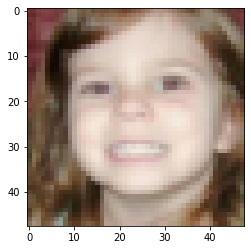

Happiness


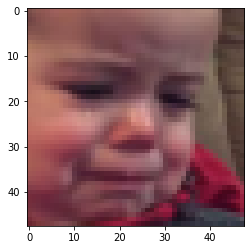

Sadness


In [26]:
#After Resizing
for i in range(0,5):
    plt.imshow(images_train_resize[i])
    plt.show()
    print(emotional_classes[labels_train[i]])   

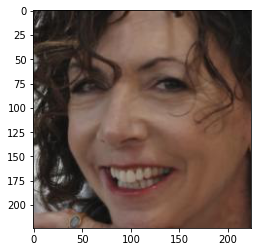

Happiness


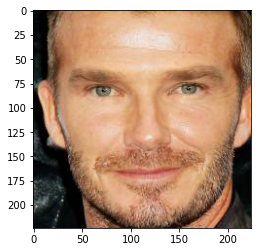

Contempt


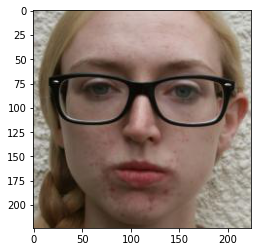

Neutral


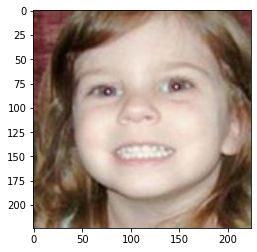

Happiness


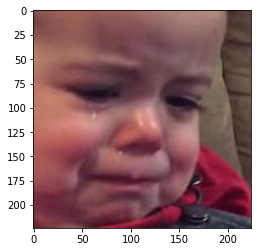

Sadness


In [27]:
#Before Resizing
for i in range(0,5):
    plt.imshow(images_train[i])
    plt.show()
    print(emotional_classes[labels_train[i]])   

### Validation Data

In [28]:
#Define Directory of Labels
data_path_labels_val = '/Data/AffectNet/val_set/annotations'
data_dir_list_labels_val = os.listdir(data_path_labels_val)

In [29]:
#Define Directory of Images
data_path_images_val = '/Data/AffectNet/val_set/images'
data_dir_list_images_val = os.listdir(data_path_images_val)

In [30]:
#Count Subjects
print(len(data_dir_list_labels_val)//4)
print(len(data_dir_list_images_val))

3999
3999


In [31]:
#Create List each for training features and labels
images_val = []
labels_val = []

#Read training features and training labels and store in list
for i in range(len(data_dir_list_images_val)):
    input_img=plt.imread('/Data/AffectNet/val_set/images/' + data_dir_list_images_val[i])
    images_val.append(input_img)
    
    temp_id = data_dir_list_images_val[i].rsplit('.jpg')[0] 
    labels_val.append(int(np.load('/Data/AffectNet/val_set/annotations/' + temp_id + "_exp.npy")))

In [32]:
#Count Subjects
print(len(images_val))
print(len(labels_val))

3999
3999


In [33]:
print(images_val[0].shape)
print(images_val[0].shape)

(224, 224, 3)
(224, 224, 3)


In [34]:
labels_val[0:3]

[2, 2, 7]

#### Resizing Images_Val

In [35]:
#Create List of Resized Images with 48 x 48 Pixels
images_val_resize = [rescale_image(i) for i in images_val]

In [36]:
#Count Subjects
print(len(images_val))
print(len(images_val_resize))

3999
3999


In [37]:
print(images_val[0].shape)
print(images_val_resize[0].shape)

(224, 224, 3)
(48, 48, 3)


# Data Pre-Processing

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
#Identify Training Labels
np.unique(labels_train)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [40]:
#Identify Val Labels
np.unique(labels_val)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [41]:
#Identify Training Label Distribution
unique, counts = np.unique(labels_train, return_counts = True)
dict(zip(unique, counts))

{0: 74874, 1: 134415, 2: 25459, 3: 14090, 4: 6378, 5: 3803, 6: 24882, 7: 3750}

In [42]:
#Identify Test Label Distribution
unique, counts = np.unique(labels_val, return_counts = True)
dict(zip(unique, counts))

{0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 499}

In [43]:
#Identify Emotion Contempt Indices in Val Data
indices_val = []

for index, item in enumerate(labels_val):
    if item == 7:
        indices_val.append(index)

In [44]:
#Check Identified Indices
indices_val[0:10]

[2, 10, 15, 32, 37, 38, 39, 44, 54, 55]

In [45]:
#Cross-Check Emotion Indices
labels_val[0:11]

[2, 2, 7, 5, 2, 4, 1, 3, 5, 1, 7]

In [46]:
#Identify Emotion Contempt Indices in Training Data
indices_train = []

for index, item in enumerate(labels_train):
    if item == 7:
        indices_train.append(index)

In [47]:
#Check Identified Indices
indices_train[0:10]

[1, 249, 364, 395, 558, 728, 730, 776, 800, 811]

In [48]:
#Cross-Check Emotion Indices
labels_train[0:11]

[1, 7, 0, 1, 2, 2, 0, 5, 1, 0, 2]

In [49]:
#Check Feature and Label Size
print(len(labels_train))
#print(len(images_train_resize))

287651


In [50]:
#Check Feature and Label Size
print(len(labels_val))
#print(len(images_val_resize))

3999


In [51]:
#Pre-Check Feature and Label Size After Contempt Elimination
print(287651 - 3750)
print(3999 - 499)

283901
3500


In [52]:
#Delete Contempt from Features and Labels
#images_train = np.delete(images_train, indices_train, axis=0)
images_train_resize = np.delete(images_train_resize, indices_train, axis=0)
labels_train = np.delete(labels_train, indices_train, axis=0)

In [53]:
#Delete Contempt from Features and Labels
#images_val = np.delete(images_val, indices_val, axis=0)
images_val_resize = np.delete(images_val_resize, indices_val, axis=0)
labels_val = np.delete(labels_val, indices_val, axis=0)

In [54]:
#Check Feature and Label Size After Contempt Elimination
print(len(labels_train))
#print(len(images_train))
print(len(images_train_resize))

283901
283901


In [55]:
#Check Feature and Label Size After Contempt Elimination
print(len(labels_val))
#print(len(images_val))
print(len(images_val_resize))

3500
3500


In [56]:
#Convert Training Data into Numpy Array
#X_train = np.array(images_train)
X_train = np.array(images_train_resize)
y_train = np.array(labels_train)

In [57]:
#Check Array Shape
print(X_train.shape)
print(y_train.shape)

(283901, 48, 48, 3)
(283901,)


In [58]:
#Convert Test Data into Numpy Array
#X_val = np.array(images_val)
X_val = np.array(images_val_resize)
y_val = np.array(labels_val)

In [59]:
#Check Array Shape
print(y_train.shape)
print(y_val.shape)

(283901,)
(3500,)


In [60]:
#Check unique Label Elements
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

In [61]:
#Check unique Label Elements
np.unique(y_val)

array([0, 1, 2, 3, 4, 5, 6])

In [62]:
#Identify Training Label Distribution
#0: Neutral, 1: Happiness, 2: Sadness, 3: Surprise, 4: Fear, 5: Disgust, 6: Anger, 7: Contempt,
unique, counts = np.unique(y_train, return_counts = True)
dict(zip(unique, counts))

{0: 74874, 1: 134415, 2: 25459, 3: 14090, 4: 6378, 5: 3803, 6: 24882}

In [63]:
#Identify Training Label Distribution
#0: Neutral, 1: Happiness, 2: Sadness, 3: Surprise, 4: Fear, 5: Disgust, 6: Anger, 7: Contempt,
unique, counts = np.unique(y_val, return_counts = True)
dict(zip(unique, counts))

{0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500}

In [64]:
#Transform/Categorize Label Elements
Y_train = np_utils.to_categorical(y_train, 7)
Y_val = np_utils.to_categorical(y_val, 7)

In [65]:
#Check Categorized labels
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [66]:
#Check Categorized labels
Y_val

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [67]:
#Check Amount and Shape of Training Data
print(X_train.shape, Y_train.shape)

(283901, 48, 48, 3) (283901, 7)


In [68]:
#Check Amount and Shape of Test Data
print(X_val.shape, Y_val.shape)

(3500, 48, 48, 3) (3500, 7)


Happiness


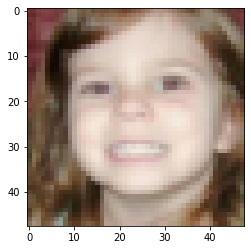

In [69]:
#Cross-Check Input and Output Variable
print(emotional_classes[int(np.where(Y_train[2]==1)[0])])
plt.imshow(X_train[2])
plt.show()

In [70]:
#Normalization of Training Data
#X_train = X_train / 255
#X_val = X_val / 255

In [71]:
#Check Training Data
print(X_train[0].min())
print(X_train[0].mean())
print(X_train[0].max())

0.06456208862108327
0.3102296838855295
0.7234366135360275


In [72]:
#Check Training and Test Data
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(283901, 48, 48, 3)
(283901, 7)
(3500, 48, 48, 3)
(3500, 7)


In [73]:
#New - Start

In [74]:
#Combine X_train + X_val = X
x = np.concatenate((X_train, X_val), axis=0)

In [75]:
x.shape

(287401, 48, 48, 3)

In [76]:
#Combine Y_train + Y_val = Y
y = np.concatenate((Y_train, Y_val), axis=0)

In [77]:
y.shape

(287401, 7)

### Split Total Data into Training and Test Set

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

Happiness


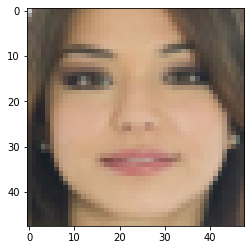

In [79]:
#Cross-Check Input and Output Variable
print(emotional_classes[int(np.where(Y_train[2]==1)[0])])
plt.imshow(X_train[2])
plt.show()

In [80]:
#Check Training Data
print(X_train[0].min())
print(X_train[0].mean())
print(X_train[0].max())

0.07110101335784291
0.3878495079803449
0.9616200929491917


In [81]:
#Check Test Data
print(X_test[0].min())
print(X_test[0].mean())
print(X_test[0].max())

0.03735985032336968
0.36019268838035196
0.9640486939579774


In [82]:
#Check Training and Test Data
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(229920, 48, 48, 3)
(229920, 7)
(57481, 48, 48, 3)
(57481, 7)


In [83]:
Y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [84]:
#Identify Training Label Distribution
unique, counts = np.unique(Y_train, return_counts = True)
dict(zip(unique, counts))

{0.0: 1379520, 1.0: 229920}

In [85]:
dist_val = pd.DataFrame(Y_train, columns=emotional_classes[0:7])
dist_val.value_counts()

Neutral  Happiness  Sadness  Surprise  Fear  Disgust  Anger
0.0      1.0        0.0      0.0       0.0   0.0      0.0      107932
1.0      0.0        0.0      0.0       0.0   0.0      0.0       60299
0.0      0.0        1.0      0.0       0.0   0.0      0.0       20767
                    0.0      0.0       0.0   0.0      1.0       20306
                             1.0       0.0   0.0      0.0       11672
                             0.0       1.0   0.0      0.0        5502
                                       0.0   1.0      0.0        3442
dtype: int64

In [86]:
#Identify Training Label Distribution
unique, counts = np.unique(Y_test, return_counts = True)
dict(zip(unique, counts))

{0.0: 344886, 1.0: 57481}

In [87]:
dist_val = pd.DataFrame(Y_test, columns=emotional_classes[0:7])
dist_val.value_counts()

Neutral  Happiness  Sadness  Surprise  Fear  Disgust  Anger
0.0      1.0        0.0      0.0       0.0   0.0      0.0      26983
1.0      0.0        0.0      0.0       0.0   0.0      0.0      15075
0.0      0.0        1.0      0.0       0.0   0.0      0.0       5192
                    0.0      0.0       0.0   0.0      1.0       5076
                             1.0       0.0   0.0      0.0       2918
                             0.0       1.0   0.0      0.0       1376
                                       0.0   1.0      0.0        861
dtype: int64

In [88]:
# New - End

### Split Training Data into Training and Validation Sets

In [89]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, stratify=Y_train)

In [90]:
print(X_train.shape, Y_train.shape)

(160944, 48, 48, 3) (160944, 7)


In [91]:
#Convert Valid Data into Numpy Array
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [92]:
print(X_val.shape, Y_val.shape)

(68976, 48, 48, 3) (68976, 7)


In [93]:
#Check Array Shape
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(160944, 7)
(68976, 7)
(57481, 7)


In [94]:
#Check Amount and Shape of Training Data
print(X_train.shape, Y_train.shape)

(160944, 48, 48, 3) (160944, 7)


In [95]:
#Check Amount and Shape of Test Data
print(X_val.shape, Y_val.shape)

(68976, 48, 48, 3) (68976, 7)


In [96]:
print(X_test.shape, Y_test.shape)

(57481, 48, 48, 3) (57481, 7)


# ML Model Building

In [97]:
#Import Package(s)
from tensorflow import keras

In [98]:
#Import Package(s)
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.preprocessing.image import ImageDataGenerator

In [99]:
#Import Package(s)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [100]:
#Build ImageDataGenerator
datagen_train = ImageDataGenerator(
        featurewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_center=False,  
        samplewise_std_normalization=False,  
        #rescale=1/255, #or 1./255 -1 for 8-bit images, rescale by 1/255 to have pixel values in the range 0 and 1
        ##after resizing range already between 0 and 1
        #zca_whitening=False,  
        #rotation_range=10, #Random Rotation between 0 and 360 degrees, empty areas filled by different techniques, e. g. "nearest" -> nearest pixel values 
        #zoom_range = 20.0, #Randomly Zooms In or Out 
        #width_shift_range=0.1, #Random Horizontal Shifts, float number -> percentage of pixels, integer number -> number of pixels  
        #height_shift_range=0.1, #Random Vertical Shifts, float number -> percentage of pixels, integer number -> number of pixels
        horizontal_flip=False, #Useful only for symmetrical objects
        vertical_flip=False)  #Useful only for symmetrical objects

datagen_valid = ImageDataGenerator()

In [101]:
#Fit ImageDataGenerator
datagen_train.fit(X_train)

In [102]:
#Define Epochs, Batch Size and Steps per Epoch
epochs = 50
batch_size = 128
steps_per_epoch = len(X_train)//batch_size

In [103]:
#Check Epochs, Batch Size and Steps per Epoch
print(epochs)
print(batch_size) 
print(steps_per_epoch)

50
128
1257


In [104]:
#Load Training and Validation Generators
train_generator = datagen_train.flow(X_train, Y_train, batch_size=batch_size)
valid_generator = datagen_valid.flow(X_val, Y_val, batch_size=batch_size)

In [105]:
#Check Training Shape
input_shape = X_train.shape[1:4]
print(input_shape)

(48, 48, 3)


In [106]:
#Check Training Data
print(X_train[0].min())
print(X_train[0].mean())
print(X_train[0].max())

1.5631434490609666e-05
0.3836418036463727
0.9548058153728197


In [107]:
#Check Validation Data
print(X_val[0].min())
print(X_val[0].mean())
print(X_val[0].max())

0.0006010784478693198
0.46547937141420354
1.0


In [108]:
#ML Model Building
model = Sequential()

model.add(Conv2D(32, (5, 5), padding="same", activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='softmax'))

2022-04-10 14:08:38.392120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43439 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-04-10 14:08:38.393778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43439 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6


In [109]:
#Check Model Structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       7

In [110]:
#Define Callbacks
my_callbacks = [
    #tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='Model/mdl_affectNet_resized_vam.hdf5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ReduceLROnPlateau(monitor='val_accuracy', #'val_loss',
                      patience=3,
                      factor=0.1,   
                      min_lr=0.000000001,
                      min_delta=0.0001,
                      verbose=1)
]

In [111]:
#Define Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
#opt = tf.keras.optimizers.SGD(learning_rate=0.0001)

In [112]:
#Compile Model
model.compile(loss="categorical_crossentropy", 
              optimizer=opt, #opt, #adam
              metrics=["accuracy"]
             )

# Model Training

In [113]:
#Train Model
history = model.fit(train_generator,
          epochs=epochs, 
          validation_data=valid_generator,
          callbacks = [my_callbacks],
          verbose=1)

2022-04-10 14:08:38.893646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-10 14:08:40.057332: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2022-04-10 14:08:41.520909: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1258/1258 [==============================] - 20s 14ms/step - loss: 1.2819 - accuracy: 0.5533 - val_loss: 1.0304 - val_accuracy: 0.6389

Epoch 00001: val_accuracy improved from -inf to 0.63890, saving model to Model/mdl_affectNet_resized_vam.hdf5
Epoch 2/50
1258/1258 [==============================] - 17s 13ms/step - loss: 1.0455 - accuracy: 0.6422 - val_loss: 0.9599 - val_accuracy: 0.6690

Epoch 00002: val_accuracy improved from 0.63890 to 0.66897, saving model to Model/mdl_affectNet_resized_vam.hdf5
Epoch 3/50
1258/1258 [==============================] - 16s 13ms/step - loss: 0.9691 - accuracy: 0.6631 - val_loss: 0.8894 - val_accuracy: 0.6869

Epoch 00003: val_accuracy improved from 0.66897 to 0.68693, saving model to Model/mdl_affectNet_resized_vam.hdf5
Epoch 4/50
1258/1258 [==============================] - 17s 13ms/step - loss: 0.9180 - accuracy: 0.6808 - val_loss: 0.8514 - val_accuracy: 0.6986

Epoch 00004: val_accuracy improved from 0.68693 to 0.69862, saving model to Model/mdl_a

In [114]:
#Identify Keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

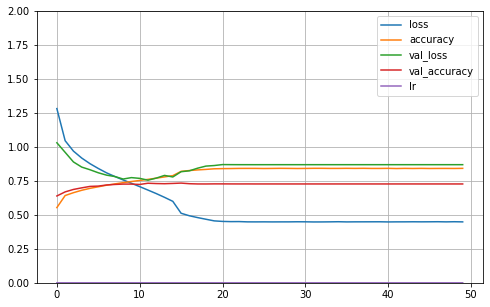

In [115]:
#Visualize Keys
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
#save_fig("keras_learning_curves_plot")
plt.show()

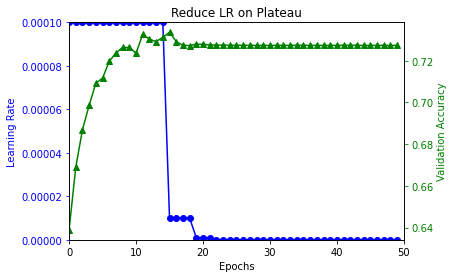

In [116]:
#Visualize LR on Plateau
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, epochs)
plt.gca().set_ylim(0, 0.0001)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_accuracy"], "g^-")
ax2.set_ylabel('Validation Accuracy', color='g')
ax2.tick_params('y', colors='g')

plt.title("Reduce LR on Plateau", fontsize=12)
plt.show()

# Model Evaluation

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [118]:
print(X_test.shape, Y_test.shape)

(57481, 48, 48, 3) (57481, 7)


In [119]:
#Predict Labels for Test Set
preds = model.predict(X_test)

In [120]:
#Check Predictions
preds

array([[5.4472607e-01, 3.0550346e-04, 4.2779890e-01, ..., 1.0128488e-03,
        5.6082272e-04, 2.4325129e-02],
       [2.4800528e-02, 9.5714641e-01, 3.8058618e-03, ..., 4.8251482e-04,
        3.5355985e-03, 4.2777769e-03],
       [8.8283581e-01, 9.0373931e-03, 7.7721119e-02, ..., 1.9722215e-03,
        1.0153294e-03, 1.2996098e-02],
       ...,
       [1.3387302e-03, 1.8927902e-03, 5.6026888e-04, ..., 1.4133223e-03,
        5.7058390e-02, 9.3548226e-01],
       [1.5463302e-01, 7.0154234e-03, 5.4890402e-02, ..., 4.1148067e-03,
        5.4683287e-02, 7.2079843e-01],
       [1.2934825e-05, 9.9994314e-01, 2.5386578e-07, ..., 5.7337864e-08,
        5.1576183e-07, 7.0025510e-07]], dtype=float32)

In [121]:
#Check Predictions
len(preds)

57481

In [122]:
#Check True Labels
Y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [123]:
#Check Predictions' Shape
preds.shape

(57481, 7)

In [124]:
#Function to Get Single Prediction Class
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))
  
  for i in range(len(preds)):
    pred_class[i] = np.argmax(preds[i])
  
  return pred_class

In [125]:
#Get Single Prediction Class
predicted_class = get_class(preds)

In [126]:
#Check Single Prediction Classes
predicted_class[0:10]

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [127]:
#Check Shape of Single Prediction Classes
predicted_class.shape

(57481, 1)

In [128]:
#Check Shape of True Classes
Y_test.shape

(57481, 7)

In [129]:
#Get Single True Class
Y_test = Y_test.argmax(axis=1)

In [130]:
#Check Single True Class
Y_test

array([2, 1, 0, ..., 6, 2, 1])

In [131]:
#Create Confusion Matrix
cm = confusion_matrix(Y_test, predicted_class)

In [132]:
#Show Confusion Matrix
cm

array([[10634,  1875,   943,   465,    64,     0,  1094],
       [ 1856, 24368,   244,   292,    21,     4,   198],
       [ 1709,   326,  2447,   117,    91,     1,   501],
       [  866,   522,   116,  1140,   150,     0,   124],
       [  212,   128,   195,   350,   346,     0,   145],
       [  146,   134,   109,    25,    13,     0,   434],
       [ 1391,   283,   305,   108,    59,     3,  2927]])

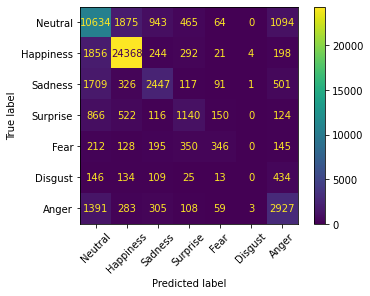

In [133]:
#Show Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(Y_test, predicted_class, display_labels=emotional_classes[0:7], xticks_rotation=45)
plt.show()

In [134]:
#Show Valuation Metrics
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test, predicted_class)))

print('Micro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test, predicted_class, average='weighted')))


Accuracy: 0.73

Micro Precision: 0.73
Micro Recall: 0.73
Micro F1-score: 0.73

Macro Precision: 0.51
Macro Recall: 0.47
Macro F1-score: 0.48

Weighted Precision: 0.71
Weighted Recall: 0.73
Weighted F1-score: 0.72


In [135]:
#Check Emotional Classes
emotional_classes

['Neutral',
 'Happiness',
 'Sadness',
 'Surprise',
 'Fear',
 'Disgust',
 'Anger',
 'Contempt']

In [136]:
#Show Classification Report
print('\nClassification Report\n')
print(classification_report(Y_test, predicted_class, target_names=emotional_classes[0:7]))


Classification Report

              precision    recall  f1-score   support

     Neutral       0.63      0.71      0.67     15075
   Happiness       0.88      0.90      0.89     26983
     Sadness       0.56      0.47      0.51      5192
    Surprise       0.46      0.39      0.42      2918
        Fear       0.47      0.25      0.33      1376
     Disgust       0.00      0.00      0.00       861
       Anger       0.54      0.58      0.56      5076

    accuracy                           0.73     57481
   macro avg       0.51      0.47      0.48     57481
weighted avg       0.71      0.73      0.72     57481



In [137]:
clf_report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predicted_class, target_names=emotional_classes[0:7], output_dict=True)).transpose()
clf_report

precision    recall  f1-score       support
Neutral        0.632449  0.705406  0.666938  15075.000000
Happiness      0.881748  0.903087  0.892290  26983.000000
Sadness        0.561367  0.471302  0.512407   5192.000000
Surprise       0.456548  0.390679  0.421053   2918.000000
Fear           0.465054  0.251453  0.326415   1376.000000
Disgust        0.000000  0.000000  0.000000    861.000000
Anger          0.539738  0.576635  0.557577   5076.000000
accuracy       0.728275  0.728275  0.728275      0.728275
macro avg      0.505272  0.471223  0.482383  57481.000000
weighted avg   0.712459  0.728275  0.718485  57481.000000

In [138]:
os.chdir("/Data/AffectNet/")

In [139]:
clf_report.to_csv('Classification_Report/{}_Classfication_Report_AffectNet_lastTrainedModel_resized_run.csv'.format(t), sep=',', index= True)

In [140]:
print('{}_Classfication_Report_AffectNet_lastTrainedModel_resized_run.csv'.format(t))

20220410_Classfication_Report_AffectNet_lastTrainedModel_resized_run.csv


## Evaluation with Model Having Highest Val_Accuracy

In [141]:
print(X_test.shape, Y_test.shape)

(57481, 48, 48, 3) (57481,)


In [142]:
#Load Model with Lowest Val_Loss
model = keras.models.load_model('Model/mdl_affectNet_resized_vam.hdf5') #model including optimizer state
#model = model.load_weights(checkpoint_filepath) #model, but state of the optimizer is discarded

In [143]:
#Predict Labels for Test Set
preds = model.predict(X_test)

In [144]:
#Check Predictions
preds

array([[6.6193843e-01, 5.1144656e-04, 3.0672300e-01, ..., 8.2676398e-04,
        5.0932635e-04, 2.7998755e-02],
       [4.4995237e-02, 9.2849779e-01, 5.5803023e-03, ..., 6.1057520e-04,
        5.8510182e-03, 8.3238184e-03],
       [8.3782125e-01, 1.1338142e-02, 1.0313803e-01, ..., 4.1601108e-03,
        1.7172917e-03, 1.8329412e-02],
       ...,
       [3.5056365e-03, 6.4219669e-03, 1.2120090e-03, ..., 3.1066099e-03,
        6.8478659e-02, 9.1153997e-01],
       [1.9145750e-01, 1.0962877e-02, 5.4338023e-02, ..., 4.3812799e-03,
        5.3052660e-02, 6.8110251e-01],
       [4.4613607e-05, 9.9982232e-01, 1.7113922e-06, ..., 4.5276121e-07,
        2.7246365e-06, 4.6075625e-06]], dtype=float32)

In [145]:
#Check Predictions
len(preds)

57481

In [146]:
#Check True Labels
Y_test

array([2, 1, 0, ..., 6, 2, 1])

In [147]:
#Check Predictions' Shape
preds.shape

(57481, 7)

In [148]:
#Function to Get Single Prediction Class
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))
  
  for i in range(len(preds)):
    pred_class[i] = np.argmax(preds[i])
  
  return pred_class

In [149]:
#Get Single Prediction Class
predicted_class = get_class(preds)

In [150]:
#Check Single Prediction Classes
predicted_class[0:10]

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [151]:
#Check Shape of Single Prediction Classes
predicted_class.shape

(57481, 1)

In [152]:
#Check Shape of True Classes
Y_test.shape

(57481,)

In [153]:
#Check Single True Class
Y_test

array([2, 1, 0, ..., 6, 2, 1])

In [154]:
#Create Confusion Matrix
cm = confusion_matrix(Y_test, predicted_class)

In [155]:
#Show Confusion Matrix
cm

array([[11118,  1742,   785,   395,    45,     0,   990],
       [ 1982, 24328,   224,   240,    19,     1,   189],
       [ 1844,   303,  2368,   102,    80,     0,   495],
       [  967,   517,   106,  1074,   142,     0,   112],
       [  244,   119,   197,   353,   317,     0,   146],
       [  164,   128,   104,    23,    13,     0,   429],
       [ 1525,   264,   276,    95,    56,     1,  2859]])

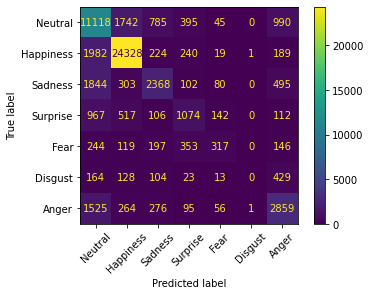

In [156]:
#Show Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(Y_test, predicted_class, display_labels=emotional_classes[0:7], xticks_rotation=45)
plt.show()

In [157]:
#Show Valuation Metrics
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test, predicted_class)))

print('Micro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test, predicted_class, average='weighted')))


Accuracy: 0.73

Micro Precision: 0.73
Micro Recall: 0.73
Micro F1-score: 0.73

Macro Precision: 0.51
Macro Recall: 0.47
Macro F1-score: 0.48

Weighted Precision: 0.72
Weighted Recall: 0.73
Weighted F1-score: 0.72


In [158]:
#Check Emotional Classes
emotional_classes

['Neutral',
 'Happiness',
 'Sadness',
 'Surprise',
 'Fear',
 'Disgust',
 'Anger',
 'Contempt']

In [159]:
#Show Classification Report
print('\nClassification Report\n')
print(classification_report(Y_test, predicted_class, target_names=emotional_classes[0:7]))


Classification Report

              precision    recall  f1-score   support

     Neutral       0.62      0.74      0.68     15075
   Happiness       0.89      0.90      0.89     26983
     Sadness       0.58      0.46      0.51      5192
    Surprise       0.47      0.37      0.41      2918
        Fear       0.47      0.23      0.31      1376
     Disgust       0.00      0.00      0.00       861
       Anger       0.55      0.56      0.56      5076

    accuracy                           0.73     57481
   macro avg       0.51      0.47      0.48     57481
weighted avg       0.72      0.73      0.72     57481



In [160]:
clf_report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predicted_class, target_names=emotional_classes[0:7], output_dict=True)).transpose()
clf_report

precision    recall  f1-score      support
Neutral        0.623067  0.737512  0.675476  15075.00000
Happiness      0.887851  0.901605  0.894675  26983.00000
Sadness        0.583251  0.456086  0.511889   5192.00000
Surprise       0.470640  0.368060  0.413077   2918.00000
Fear           0.471726  0.230378  0.309570   1376.00000
Disgust        0.000000  0.000000  0.000000    861.00000
Anger          0.547701  0.563239  0.555361   5076.00000
accuracy       0.731790  0.731790  0.731790      0.73179
macro avg      0.512034  0.465269  0.480007  57481.00000
weighted avg   0.716418  0.731790  0.720793  57481.00000

In [161]:
clf_report.to_csv('Classification_Report/{}_Classfication_Report_AffectNet_bestTrainedModel_resized_run.csv'.format(t), sep=',', index= True)

In [162]:
print('{}_Classfication_Report_AffectNet_bestTrainedModel_resized_run.csv'.format(t))

20220410_Classfication_Report_AffectNet_bestTrainedModel_resized_run.csv
